In [1]:
import torch
from torch import nn
from torchvision import transforms
from pathlib import Path

from dataset import *
from data_preprocessing import *
from utils import *
from unet import *
from attention import *
from time_embedding import *
from ddpm import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
unet = UNET(n_classes=2, in_channels=3, out_channels=3, channels=(32,64,128,256)).to(device)

In [4]:
ddpm = DDPM(beta_min=0.0001, beta_max=0.02, n_steps=1000, device=device)

In [5]:
train_data_folder = "./data/catsdogs/"

In [6]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((32, 32)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                transforms.Lambda(lambda x: x.float())
            ])

In [7]:
train_dataset = CustomDataset(root_dir=train_data_folder, transform=transform)

In [8]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=5, shuffle=True)

d:\Machine Learning\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


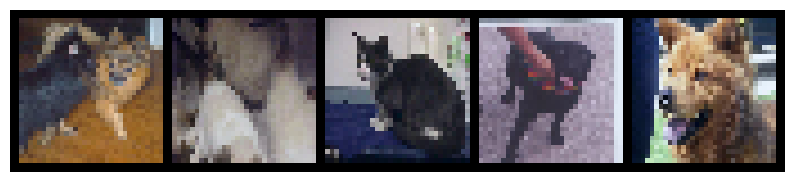

In [9]:
X, y = next(iter(train_dataloader))
show_images_grid(X)

In [11]:
unet.load_state_dict(torch.load("./Saved Models/kruto_image/unet_251.pth"))

<All keys matched successfully>

Noised Image


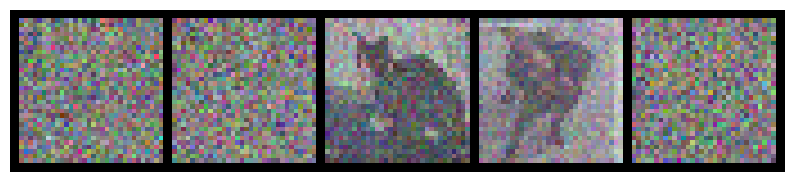

Noise Added


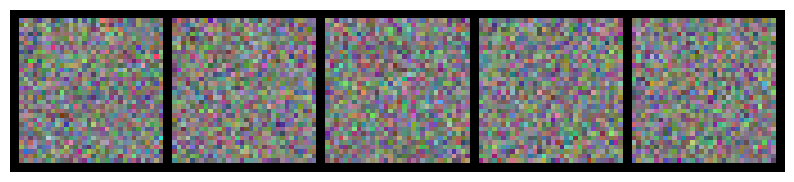

Predicted Noise


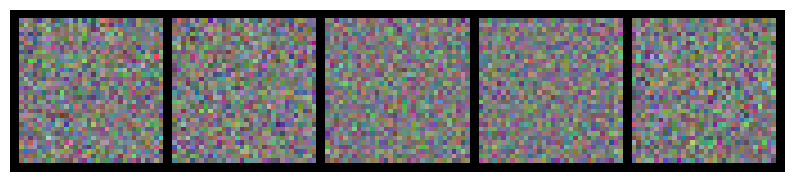

Loss
0.06632126122713089


In [18]:
with torch.inference_mode():
    xt, t, noise = ddpm.schedule(X.to(device))
    pred_noise = unet(xt, t, y.to(device))
print("Noised Image")
show_images_grid(xt)
print("Noise Added")
show_images_grid(noise)
print("Predicted Noise")
show_images_grid(pred_noise)
print("Loss")
print((F.mse_loss(pred_noise, noise)).item())

In [9]:
lr = 1e-3
epochs = 500
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
schedular = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

In [10]:
from IPython.display import display
from tqdm.notebook import trange

train_losses = []

def train(model, epochs=None):
    model.to(device)
    progress_bar = trange(epochs, desc="Progress")
    display(progress_bar)
    for epoch in progress_bar:
        model.train()
        total_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            xt, t, noise = ddpm.schedule(X)
            pred = model(xt, t, y)
            loss = loss_fn(pred, noise)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(total_loss)
        schedular.step()
        current_epoch = epoch+1

        total_loss /= len(train_dataloader)
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"./Saved Models/kruto_image/unet_{current_epoch}.pth")
        print(f"Epoch: {current_epoch} - Loss: {total_loss}")

In [11]:
train(unet, epochs=epochs)

Progress:   0%|          | 0/500 [00:00<?, ?it/s]

d:\Machine Learning\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch: 1 - Loss: 1.007222519814968
Epoch: 2 - Loss: 0.7777429431676864
Epoch: 3 - Loss: 0.6173549085855484
Epoch: 4 - Loss: 0.5017523609101773
Epoch: 5 - Loss: 0.4315370686352253
Epoch: 6 - Loss: 0.3769492283463478
Epoch: 7 - Loss: 0.3383081275969744
Epoch: 8 - Loss: 0.30144243240356444
Epoch: 9 - Loss: 0.30330625027418134
Epoch: 10 - Loss: 0.29480654522776606
Epoch: 11 - Loss: 0.28429913222789766
Epoch: 12 - Loss: 0.24779853224754333
Epoch: 13 - Loss: 0.2556162904947996
Epoch: 14 - Loss: 0.24032953809946775
Epoch: 15 - Loss: 0.2280217468738556
Epoch: 16 - Loss: 0.24471378400921823
Epoch: 17 - Loss: 0.220069907233119
Epoch: 18 - Loss: 0.22980824932456018
Epoch: 19 - Loss: 0.21445240117609501
Epoch: 20 - Loss: 0.22300501447170973
Epoch: 21 - Loss: 0.2003936752676964
Epoch: 22 - Loss: 0.20162647794932126
Epoch: 23 - Loss: 0.21242005098611116
Epoch: 24 - Loss: 0.21336902659386398
Epoch: 25 - Loss: 0.2158460894599557
Epoch: 26 - Loss: 0.2203999923542142
Epoch: 27 - Loss: 0.1920426107943058

KeyboardInterrupt: 